# Taking a Quick Look at DR1
The below code allows you to access the quasar spectra in iron. There is a more complete tutorial on the DESI Github \
The explanation there focuses on the early data release (EDR) but the methodology should still be the samee just with \
different file paths.

Be Sure to run this after you have access to the nersc file system.

`https://github.com/desihub/tutorials/blob/main/getting_started/EDR_AnalyzeZcat.ipynb`

In [1]:
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask
import os
import desispec.io
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
specprod_dir = '/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron' #Directory to DESI DR1 'Iron' is the internal name. Fuji is internal for EDR
print(specprod_dir)

/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron


In [3]:
!ls '/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits'

/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits


In [4]:
!ls '/global/cfs/cdirs/desi/spectro/redux/kibo/zcatalog/v1'

logs				  zpix-sv3-bright.fits
redux_kibo_zcatalog_v1.sha256sum  zpix-sv3-dark.fits
zall-pix-kibo.fits		  ztile-cmx-other-cumulative.fits
zall-tilecumulative-kibo.fits	  ztile-main-backup-cumulative.fits
zpix-cmx-other.fits		  ztile-main-bright-cumulative.fits
zpix-main-backup.fits		  ztile-main-dark-cumulative.fits
zpix-main-bright.fits		  ztile-special-backup-cumulative.fits
zpix-main-dark.fits		  ztile-special-bright-cumulative.fits
zpix-special-backup.fits	  ztile-special-dark-cumulative.fits
zpix-special-bright.fits	  ztile-sv1-backup-cumulative.fits
zpix-special-dark.fits		  ztile-sv1-bright-cumulative.fits
zpix-sv1-backup.fits		  ztile-sv1-dark-cumulative.fits
zpix-sv1-bright.fits		  ztile-sv1-other-cumulative.fits
zpix-sv1-dark.fits		  ztile-sv2-backup-cumulative.fits
zpix-sv1-other.fits		  ztile-sv2-bright-cumulative.fits
zpix-sv2-backup.fits		  ztile-sv2-dark-cumulative.fits
zpix-sv2-bright.fits		  ztile-sv3-backup-cumulative.fits
zpix-sv2-dark.fits		  ztile-sv3-bright-cumula

In [5]:
# This can take about 2 mins to run 
zpix_cat = Table.read('/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits', hdu="ZCATALOG")

In [6]:
QSO_tgtmask = desi_mask['QSO']

In [7]:
desi_target = zpix_cat["DESI_TARGET"]
is_qso = (desi_target & QSO_tgtmask != 0) | (zpix_cat["SV1_DESI_TARGET"] & QSO_tgtmask != 0) | \
         (zpix_cat["SV2_DESI_TARGET"] & QSO_tgtmask != 0) | (zpix_cat["SV3_DESI_TARGET"] & QSO_tgtmask != 0)

In [8]:
n_qso  = np.count_nonzero(is_qso)
#print(n_qso) #prints the number of qsos in the sample


______________

We selected the QSO off of `Targeting` Meaning that there are some that are targeted as
QSO but spectroscopically they may be galaxies so when running the code you should also 
add something to indicate that their spectral type is a QSO as well.

In [9]:
selected_data = zpix_cat[n_qso & (zpix_cat['SPECTYPE'] == 'QSO')]

______________

In [20]:
def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (selected_data["TARGETID"]==tid) & (selected_data["SURVEY"]==survey) & (selected_data["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = selected_data["HEALPIX"].astype(str)

    if "sv" in survey:
        specprod = "iron"

    specprod_dir = f"/global/cfs/cdirs/desi/spectro/redux/iron"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{target_dir}/{coadd_fname}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==selected_data["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec

In [21]:
spec_dark = get_spec_data(selected_data["TARGETID"][10], str(selected_data["SURVEY"][10]), str(selected_data["PROGRAM"][10]))


INFO:spectra.py:391:read_spectra: iotime 0.069 sec to read coadd-cmx-other-2152.fits at 2025-02-12T15:57:02.415375


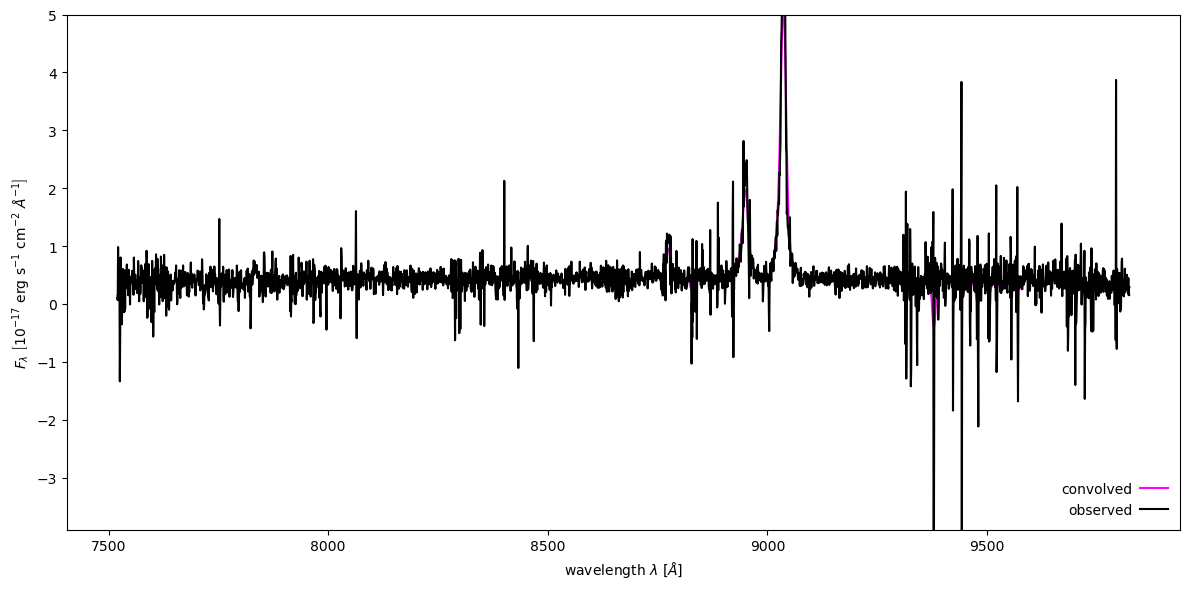

In [40]:
from astropy.convolution import convolve, Gaussian1DKernel

# Define rest-frame wavelengths of common emission lines (in Angstroms)
emission_lines = {
    "Lyα": 1215.67,        # Lyman-alpha
    "C IV": 1548.20,       # Carbon IV doublet (primary)
    "C IV (sec)": 1550.77, # Carbon IV doublet (secondary)
    "He II": 1640.42,      # Helium II
    "O III]": 1660.81,     # Oxygen [O III]
    "O III] (sec)": 1666.15,
    "C III]": 1906.68,     # Carbon [C III] doublet (primary)
    "C III] (sec)": 1908.73, # Carbon [C III] doublet (secondary)
}


# Redshift factor
z = selected_data["Z"][10]

# Redshifted wavelengths
redshifted_lines = {name: rest * (1 + z) for name, rest in emission_lines.items()}

#-- plot the spectra
fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)

axes.set_ylim(-3.9, 5)  #-- change depending on specific spectrum
axes.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

axes.set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
spec_bright = spec_dark 
#-- plot the BRIGHT TIME and DARK TIME spectra (both smoothed) on the same axis
axes.plot(spec_bright.wave[band], convolve(spec_bright.flux[band][0], Gaussian1DKernel(5)), color="magenta", label='convolved')
axes.plot(spec_dark.wave[band], spec_dark.flux[band][0], acolor="k", label='observed')

axes.legend(markerfirst=False, loc=4, handletextpad=0.5, frameon=False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()


In [29]:
Quasar_cat = zpix_cat[(zpix_cat['SPECTYPE'] == 'QSO') & 
         (zpix_cat['ZWARN'] == 0 ) & 
         (zpix_cat['OBJTYPE'] == 'TGT') & 
         (zpix_cat['ZCAT_PRIMARY'] == 1)]
         

In [30]:
import numpy as np
len(np.unique(Quasar_cat['TARGETID'])), len(Quasar_cat)

(2837687, 2837687)

In [20]:
import numpy as np
len(np.unique(Quasar_cat['TARGETID'])), len(Quasar_cat)

(1597658, 1597658)

Text(0.5, 0, 'Redshift')

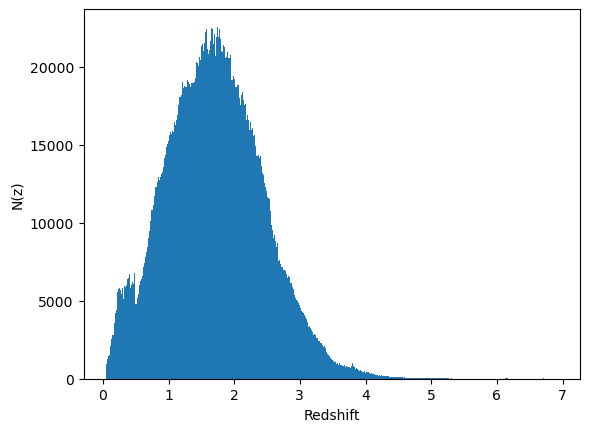

In [31]:
import matplotlib.pyplot as plt
plt.hist(Quasar_cat['Z'], bins = 'auto')
plt.ylabel('N(z)')
plt.xlabel('Redshift')

In [22]:
np.where(Quasar_cat['TARGETID'] == 39627726679704831)

(array([1243314]),)

In [23]:
Quasar_cat[1243314]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,FITMETHOD,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,DESINAME,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_BGS_B,TSNR2_ELG_B,TSNR2_GPBBACKUP_B,TSNR2_GPBBRIGHT_B,TSNR2_GPBDARK_B,TSNR2_LRG_B,TSNR2_LYA_B,TSNR2_QSO_B,TSNR2_BGS_R,TSNR2_ELG_R,TSNR2_GPBBACKUP_R,TSNR2_GPBBRIGHT_R,TSNR2_GPBDARK_R,TSNR2_LRG_R,TSNR2_LYA_R,TSNR2_QSO_R,TSNR2_BGS_Z,TSNR2_ELG_Z,TSNR2_GPBBACKUP_Z,TSNR2_GPBBRIGHT_Z,TSNR2_GPBDARK_Z,TSNR2_LRG_Z,TSNR2_LYA_Z,TSNR2_QSO_Z,TSNR2_BGS,TSNR2_ELG,TSNR2_GPBBACKUP,TSNR2_GPBBRIGHT,TSNR2_GPBDARK,TSNR2_LRG,TSNR2_LYA,TSNR2_QSO,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
,,,,,,,,,,,,,,,,,deg,deg,,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,,,arcsec,,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],bytes4,int64,bytes6,bytes20,int64,float64,int32,float64,float64,bytes22,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,int16,bool,int16,bool
39627726679704831,main,dark,27273,27273,0.6578481817795895,0.00011303067701879604,0,9385.70510929823,1.1880445468461285 .. 0.0,PCA,7847,QSO,LOZ,4,697.5895595308393,0,140.05280015065787,-2.3751356466114126,DESI J140.0528-02.3751,0.0,0.0,2015.5,5764607523034300417,1,TGT,0.9585910589583223,575,9010,1401m025,316528,1279,DEV,0.043053903,5.231595,9.760905,25.758905,107.21346,98.219666,251.45926,85.231445,20.006222,1.5592492,0.4490723,2.059646,3.8428063,10.141117,2.059646,3.8428063,10.141117,0,4.0,0.8398982,0.07804689,0.099555485,0,N/,0.0,0.0,0.0,0.0,S,3200,2,0,5764607523034300417,65537,0,131072,0,0,0,0,0,0,0,0,0,0,0,0,140.05280015065787,-2.3751356466114126,1,1122.9893,1,1,0.008,0.008,0.004,0.004,0.7580243,140.05283250095374,0.0,-2.375151695291228,0.0,59531.49211404,59531.49211404,59531.49211404,660.1361,0.12990269,297.33908,41.735035,237.71149,1.3073786,97.98926,3.5189297,2483.3718,30.01055,14211.778,2171.5457,12828.842,42.266422,0.044847522,9.064916,4397.585,110.65594,2.6870033e-05,3.732772e-06,2.123119

In [24]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

#-- input/output functions related to DESI spectra
import desispec.io


def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (Quasar_cat["TARGETID"]==tid) & (Quasar_cat["SURVEY"]==survey) & (Quasar_cat["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = Quasar_cat["HEALPIX"].astype(str)

    specprod_dir = f"/global/cfs/cdirs/desi/spectro/redux/kibo/"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{target_dir}/{coadd_fname}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==Quasar_cat["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec

In [19]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

#-- input/output functions related to DESI spectra
import desispec.io


def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (Quasar_cat["TARGETID"]==tid) & (Quasar_cat["SURVEY"]==survey) & (Quasar_cat["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = Quasar_cat["HEALPIX"].astype(str)

    specprod = "dr1"

    specprod_dir = f"/global/cfs/cdirs/desi/public/dr1/spectro/redux/iron"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{target_dir}/{coadd_fname}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==Quasar_cat["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec

In [26]:
spec = get_spec_data(39627726679704831, 'main', 'dark')

INFO:spectra.py:391:read_spectra: iotime 1.970 sec to read coadd-main-dark-27273.fits at 2024-09-16T08:49:04.681917


In [27]:
import matplotlib.pyplot as plt

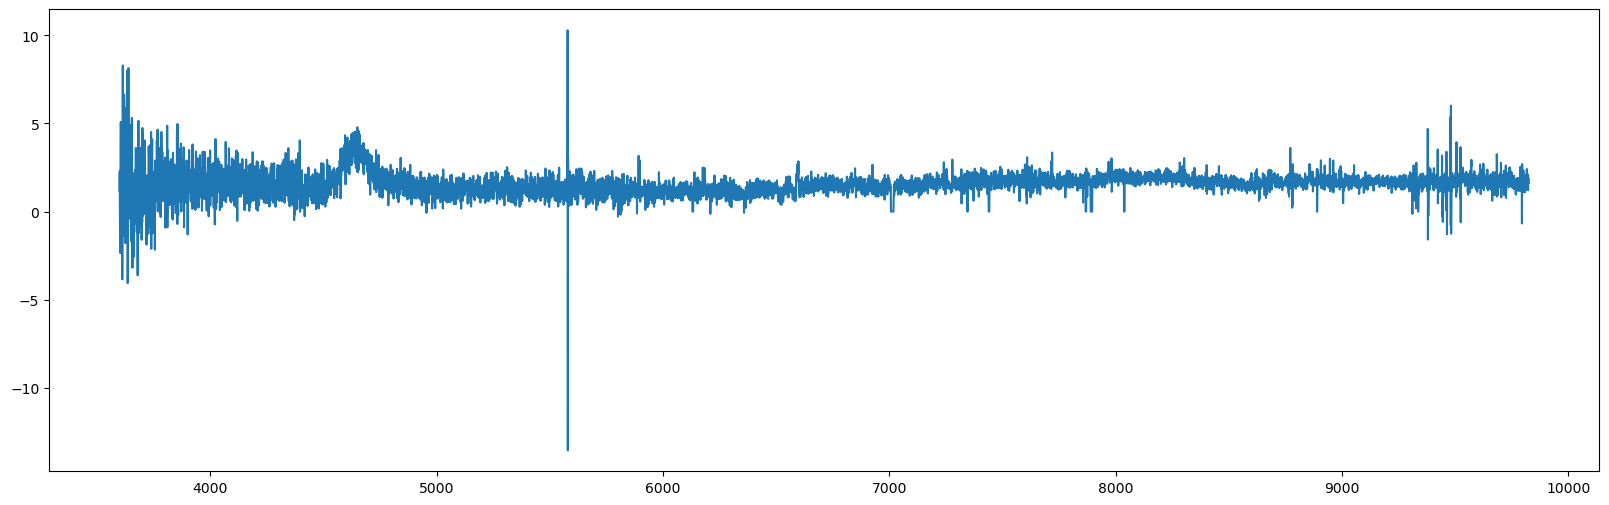

In [28]:
from desispec import coaddition

spec = coaddition.coadd_cameras(spec)
plt.figure(figsize = (20,6))
plt.plot(spec.wave['brz'], spec.flux['brz'][0])

In [26]:
np.save('Can_flux.npy', spec.flux['brz'][0])